In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.2000]), and xy 

# Volume classifier

# Optimisation

In [8]:
from tomopt.optimisation import ULorryPassiveGenerator

In [9]:
u_volume = 12
passive_gen = ULorryPassiveGenerator(volume, u_volume=u_volume, u_prob=0.5, fill_frac=0.8, x0_lorry=X0['iron'], bkg_materials=['air', 'iron'])
trn_passives = PassiveYielder(passive_gen, n_passives=4)

In [10]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [11]:
volume.get_cost()

tensor(2., grad_fn=<AddBackward0>)

In [12]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VolumeClassLoss(x02id={0:0, 1:1}, target_budget=5),
                             partial_volume_inferer=partial(DenseBlockClassifierFromX0s, n_block_voxels=u_volume, partial_x0_inferer=PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=1))

In [13]:
wrapper.load('may_demo/offset_0.pt')

In [18]:
for i,p in enumerate(volume.get_detectors()[0].panels):
    p.z.data = Tensor([1-(i*(2*0.1)/4)])

In [19]:
for i,p in enumerate(volume.get_detectors()[1].panels):
    p.z.data = Tensor([0.2-(i*(2*0.1)/4)])

In [20]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5472, 0.4661]), z=tensor([1.]), and xy span tensor([0.5315, 0.6826])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5417, 0.4275]), z=tensor([0.9500]), and xy span tensor([0.5342, 0.6833])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.4939, 0.4929]), z=tensor([0.9000]), and xy span tensor([0.5601, 0.5374])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5108, 0.3344]), z=tensor([0.8500]), and xy span tensor([0.6075, 0.5251])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.473

## Initial performance

In [21]:
test_passives = PassiveYielder(passive_gen, n_passives=200)

In [22]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])

/home/centos/volume/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [23]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

<ipython-input-23-9804e60ffd94>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])


In [24]:
df_start['gen_target'] = df_start.gen_target.astype(int)

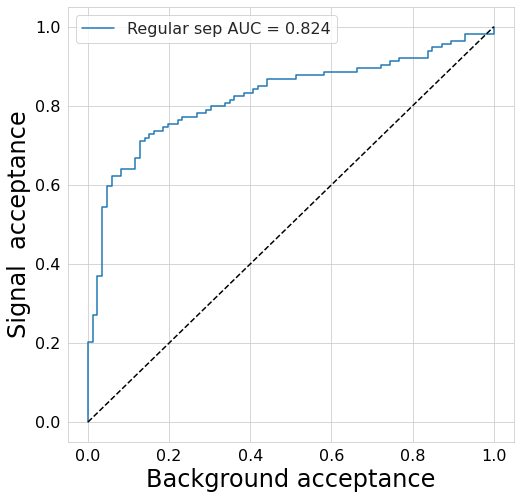

{'Regular sep': 0.8238474092207262}

In [26]:
plot_roc(df_start, labels=['Regular sep'])

## Optimise

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


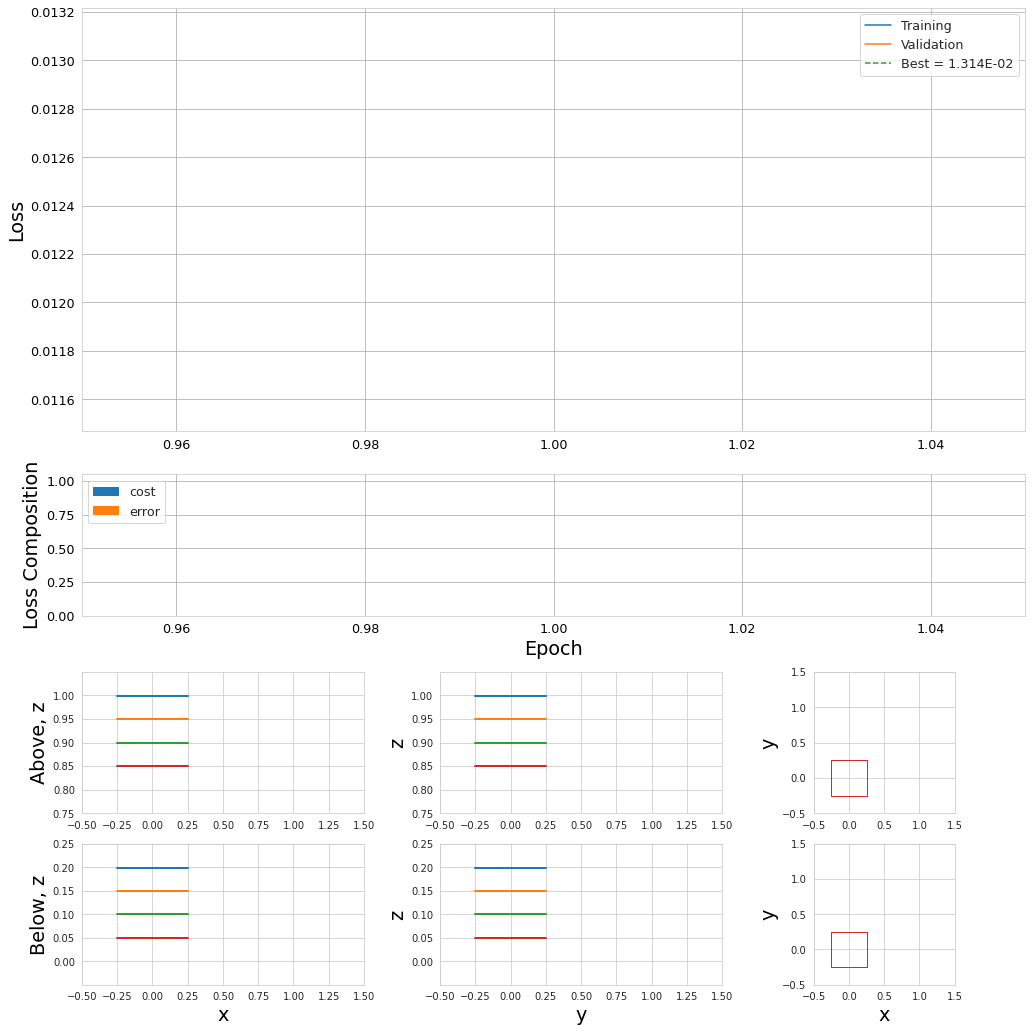

/home/centos/volume/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


Automatically setting cost coefficient to 0.013463515788316727


/home/centos/volume/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:211: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


KeyboardInterrupt: 

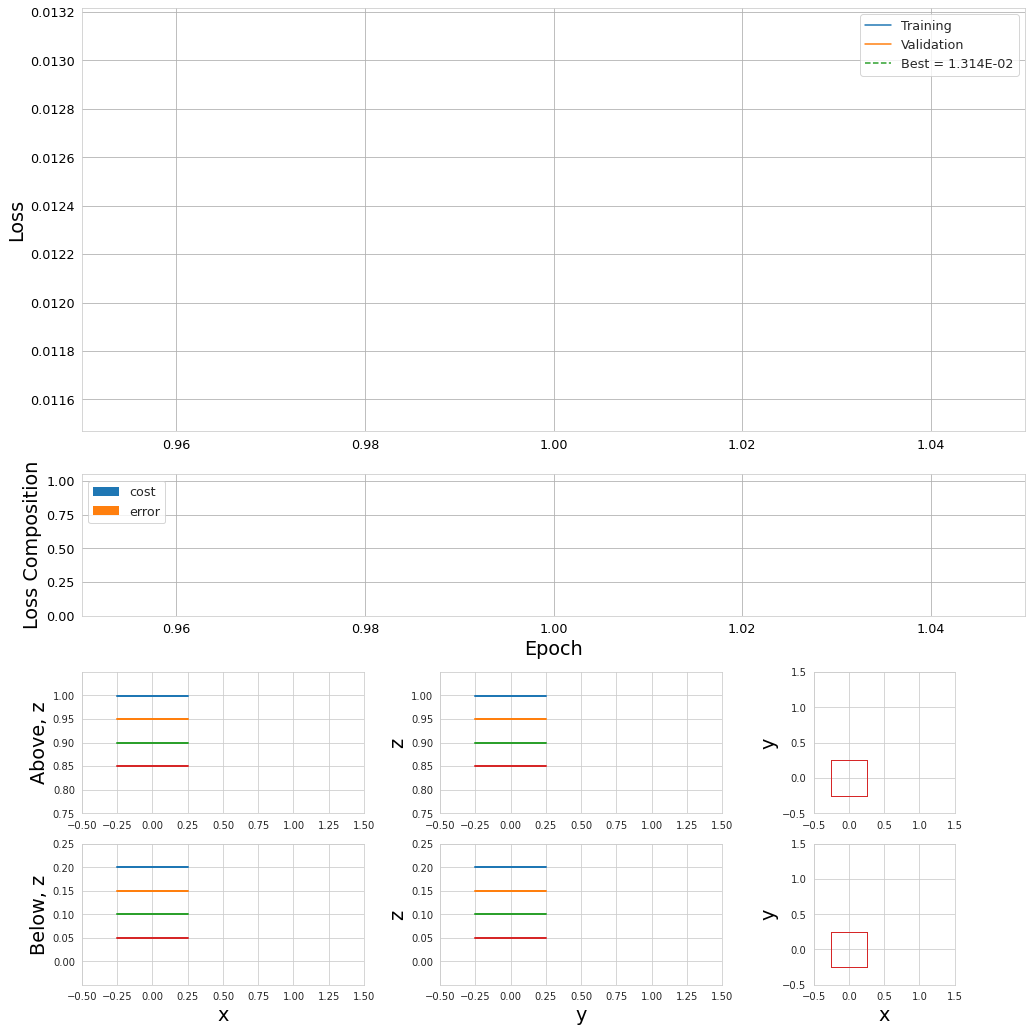

In [13]:
_ = wrapper.fit(n_epochs=120,
                passive_bs=4,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cbs=[CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.05, z_pos_rate=0.001, xy_span_rate=0.05), MuonResampler(), NoMoreNaNs(),PanelMetricLogger()])

In [114]:
wrapper.save('may_demo/offset_0.pt')

In [115]:
volume.get_cost()

tensor(2.8601, grad_fn=<AddBackward0>)

## Optimised performance

In [27]:
wrapper.load('may_demo/offset_0.pt')

In [28]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])

In [29]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

<ipython-input-29-282cd680ea81>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])


In [30]:
df_opt['gen_target'] = df_opt.gen_target.astype(int)

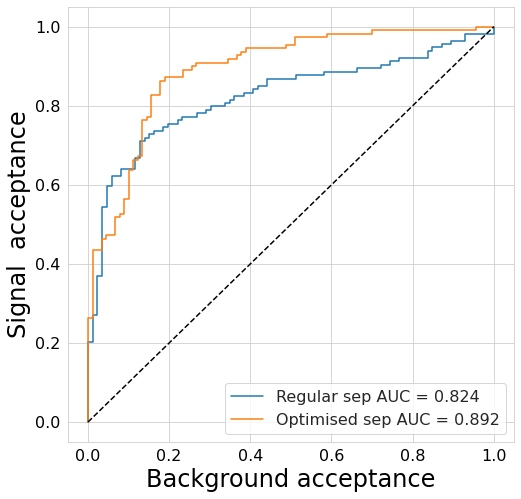

{'Regular sep': 0.8238474092207262, 'Optimised sep': 0.8917171717171718}

In [31]:
plot_roc((df_start, df_opt), labels=['Regular sep', 'Optimised sep'])